In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

In [21]:
import hydra
from hydra import compose, initialize
import matplotlib.pyplot as plt

import json
import numpy as np
import torch
import torchvision
import torchvision.transforms.functional as TF

In [4]:
with initialize(config_path="../configs/"):
    cfg = compose(config_name="train_vqbet", overrides=["include_task=bag", "use_depth=True", "dataset.train.shuffle_mode=SEQUENTIAL"])

/tmp/ipykernel_9778/3689395197.py:1: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="../configs/"):


In [5]:
train_dataset = hydra.utils.instantiate(cfg.dataset.train)

Filtering trajectories: 100%|██████████| 1000/1000 [00:43<00:00, 22.89it/s]


Using 999 videos


In [6]:
imgs, depth, done, actions = train_dataset[0]

In [7]:
traj_slice = train_dataset._subslices[0]
traj_slice.skip = 1
frames = train_dataset._get_video_frames(traj_slice)
depths = train_dataset._get_depth_frames(traj_slice)
is_padding, actions = train_dataset._get_action_slice(traj_slice)

In [14]:
metadata_path = "/home/robot_lab/data/bag_pick_up_extracted/bag/haritheja/Env1/2024-05-27--09-15-05/metadata"

with open(metadata_path, "r") as f:
    metadata = json.load(f)

In [30]:
metadata['poses']

[[-0.03929084166884422,
  -0.15500693023204803,
  -0.7175119519233704,
  0.6779423952102661,
  -0.04523186758160591,
  0.04415329545736313,
  -0.01864680089056492],
 [-0.039574313908815384,
  -0.15444917976856232,
  -0.7186422348022461,
  0.6768549680709839,
  -0.04493921622633934,
  0.0437924787402153,
  -0.01872927136719227],
 [-0.038764599710702896,
  -0.15296253561973572,
  -0.7196388840675354,
  0.6761800050735474,
  -0.04460489749908447,
  0.04393133521080017,
  -0.018459882587194443],
 [-0.03826218843460083,
  -0.15170492231845856,
  -0.7204070687294006,
  0.6756739020347595,
  -0.04443076625466347,
  0.044370993971824646,
  -0.018389679491519928],
 [-0.03808601573109627,
  -0.15142209827899933,
  -0.7207818627357483,
  0.6753474473953247,
  -0.04436219483613968,
  0.04460451751947403,
  -0.018414625898003578],
 [-0.03767311945557594,
  -0.1511869728565216,
  -0.7210303544998169,
  0.6751582026481628,
  -0.04427701234817505,
  0.04474429786205292,
  -0.018467437475919724],
 [-0.

In [19]:
intr = np.array(metadata["K"]).reshape(3, 3)

In [20]:
intr

array([[718.98345947,   0.        ,   0.        ],
       [  0.        , 718.98345947,   0.        ],
       [357.10855103, 479.05249023,   1.        ]])

In [ ]:
def transform_points(P, T):
    return (T[:3, :3] @ P.T).T + T[:3, 3]

def get_pcd(img, depth, K, T, lo_crop=None, hi_crop=None, n_sample=None):
    # img : (H, W, 3)
    H, W, _ = img.shape
    u, v = np.meshgrid(np.arange(W), np.arange(H))

    u = u.flatten()
    v = v.flatten()
    depth = depth.flatten()

    fx, fy = K[0, 0], K[1, 1]
    cx, cy = K[0, 2], K[1, 2]

    X = (u - cx) * depth / fx
    Y = (v - cy) * depth / fy
    Z = depth

    points = np.vstack((X, Y, Z)).T
    colors = img.reshape(-1, 3)

    points = transform_points(points, T)

    if lo_crop is not None and hi_crop is not None:
        lo_crop = np.array(lo_crop).reshape(1, 3)
        hi_crop = np.array(hi_crop).reshape(1, 3)
        mask = np.logical_and(lo_crop <= points, points <= hi_crop)
        mask = np.all(mask, axis=-1)

        points = points[mask]
        colors = colors[mask]

    points = torch.from_numpy(points)
    colors = torch.from_numpy(colors)

    return points, colors

In [23]:
frames[0].shape
depths[0].shape

torch.Size([1, 192, 256])

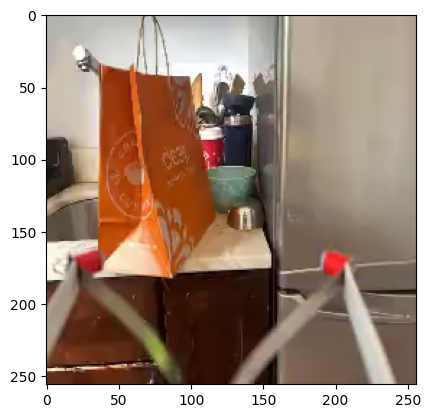

In [25]:
plt.imshow(frames[0].permute(1, 2, 0))

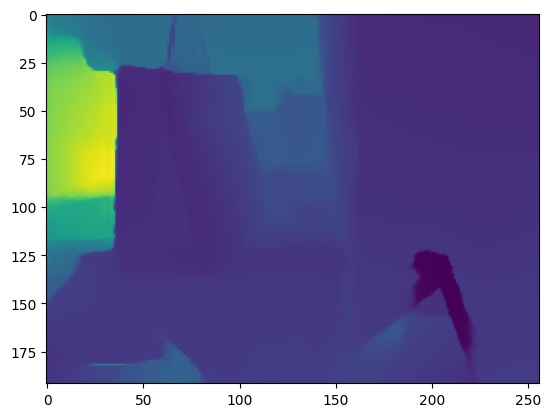

In [26]:
plt.imshow(depths[0, 0])

In [11]:
actions[0:5]

array([[-0.00385341,  0.00184502,  0.00362511, -0.00464656, -0.00940037,
         0.00519323,  0.9709395 ],
       [-0.00492516,  0.00228966,  0.00468567, -0.00411722, -0.00686131,
         0.00855697,  0.9683944 ],
       [-0.00651844,  0.00304689,  0.00622634, -0.00560991, -0.00490839,
         0.01141833,  0.96968675],
       [-0.00831966,  0.00431243,  0.00791837, -0.007783  , -0.00448113,
         0.01311433,  0.9708582 ],
       [-0.01030628,  0.00615292,  0.00983535, -0.00929463, -0.00509317,
         0.01331286,  0.9681145 ]], dtype=float32)